In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import rawpy


In [2]:
RAW_DIR = "images/raw"
COMPRESSED_DIR = "images/compressed"
COMPRESSED_COLOR_DIR = "images/compressed_color"

RAW_EXTS = {".arw", ".cr2", ".nef", ".dng", ".raf", ".rw2"}
IMAGE_EXTS = RAW_EXTS | {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp", ".gif", ".webp"}


In [3]:
def load_image(image_path, greyscale=False):
    img = None
    
    try:
        img = Image.open(image_path)
    except (Image.UnidentifiedImageError, OSError):
        with rawpy.imread(image_path) as raw:
            rgb = raw.postprocess(
                no_auto_bright=True,
                output_bps=8
            )
            img = Image.fromarray(rgb)
    
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")

    if greyscale:
        img = img.convert('L')
    else:
        img = img.convert('RGB')
            
    return img


In [4]:
def get_file_size_kb(file_path):
    return os.path.getsize(file_path) / 1024


In [5]:
def compare_images(original_path, grayscale_path, color_path):
    original_size = get_file_size_kb(original_path)
    grayscale_size = get_file_size_kb(grayscale_path)
    color_size = get_file_size_kb(color_path)

    grayscale_ratio = grayscale_size / original_size * 100
    color_ratio = color_size / original_size * 100

    try:
        original_img = load_image(original_path)
        grayscale_img = load_image(grayscale_path)
        color_img = load_image(color_path)
    except Exception as e:
        print(f"Error loading images: {e}")
        return

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_img)
    axes[0].set_title(f"Original\nSize: {original_size:.1f} KB")
    axes[0].axis('off')
    
    axes[1].imshow(grayscale_img, cmap='gray')
    axes[1].set_title(f"Grayscale Compressed\nSize: {grayscale_size:.1f} KB ({grayscale_ratio:.1f}%)")
    axes[1].axis('off')
    
    axes[2].imshow(color_img)
    axes[2].set_title(f"Color Compressed\nSize: {color_size:.1f} KB ({color_ratio:.1f}%)")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

    print(f"Original size: {original_size:.1f} KB")
    print(f"Grayscale compressed size: {grayscale_size:.1f} KB ({grayscale_ratio:.1f}% of original)")
    print(f"Color compressed size: {color_size:.1f} KB ({color_ratio:.1f}% of original)")
    print(f"Grayscale compression saved {original_size - grayscale_size:.1f} KB ({100 - grayscale_ratio:.1f}%)")
    print(f"Color compression saved {original_size - color_size:.1f} KB ({100 - color_ratio:.1f}%)")
    print("-" * 50)


In [6]:
compressed_files = list(Path(COMPRESSED_DIR).glob("*_compressed.*"))
print(f"Found {len(compressed_files)} compressed images")


Found 14 compressed images


In [7]:
sample_files = []

for file in compressed_files:
    original_name = file.stem.replace("_compressed", "")

    original_file = None
    for ext in IMAGE_EXTS:
        potential_file = Path(RAW_DIR) / f"{original_name}{ext}"
        if potential_file.exists():
            original_file = potential_file
            break
    
    if original_file is None:
        continue

    color_file = Path(COMPRESSED_COLOR_DIR) / file.name
    if not color_file.exists():
        continue
    
    sample_files.append((original_file, file, color_file))

    if len(sample_files) >= 3:
        break

print(f"Selected {len(sample_files)} sample images for comparison")


Selected 3 sample images for comparison


Sample 1: test_1.arw


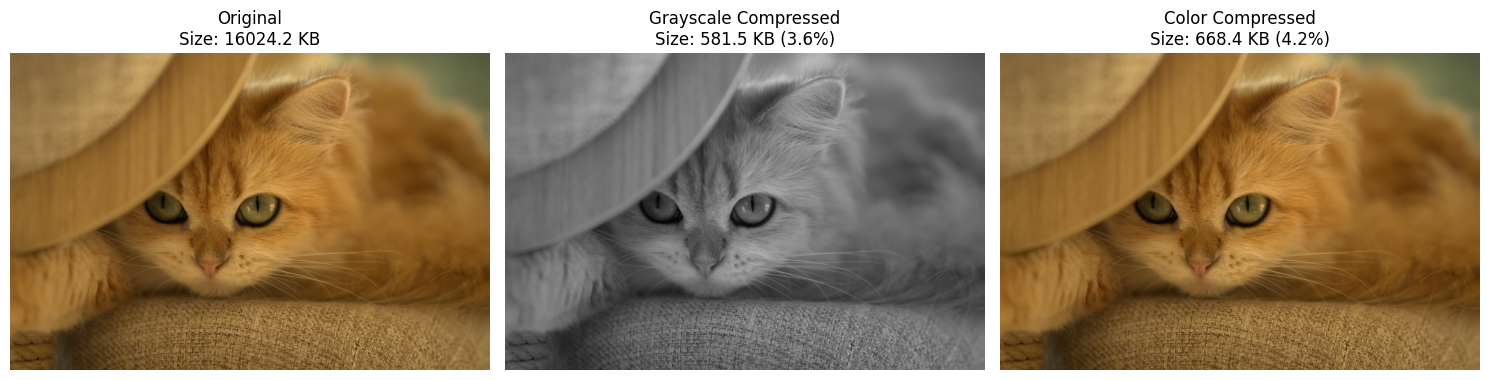

Original size: 16024.2 KB
Grayscale compressed size: 581.5 KB (3.6% of original)
Color compressed size: 668.4 KB (4.2% of original)
Grayscale compression saved 15442.7 KB (96.4%)
Color compression saved 15355.9 KB (95.8%)
--------------------------------------------------
Sample 2: IMG_4635.cr2


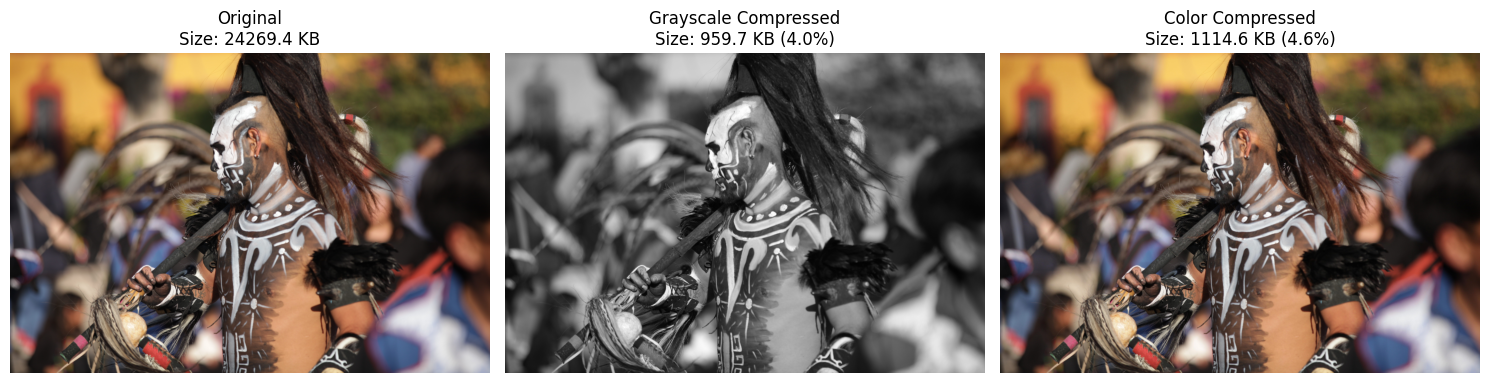

Original size: 24269.4 KB
Grayscale compressed size: 959.7 KB (4.0% of original)
Color compressed size: 1114.6 KB (4.6% of original)
Grayscale compression saved 23309.7 KB (96.0%)
Color compression saved 23154.8 KB (95.4%)
--------------------------------------------------
Sample 3: IMG_4632.cr2


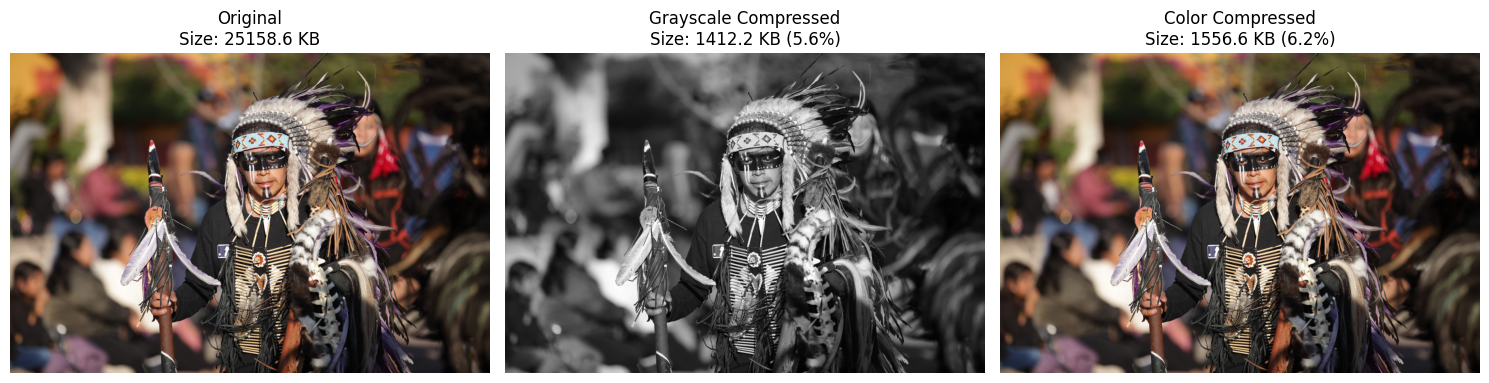

Original size: 25158.6 KB
Grayscale compressed size: 1412.2 KB (5.6% of original)
Color compressed size: 1556.6 KB (6.2% of original)
Grayscale compression saved 23746.3 KB (94.4%)
Color compression saved 23602.0 KB (93.8%)
--------------------------------------------------


In [8]:
for i, (original, grayscale, color) in enumerate(sample_files):
    print(f"Sample {i+1}: {original.name}")
    compare_images(str(original), str(grayscale), str(color))


In [9]:
all_stats = []

for file in compressed_files:
    original_name = file.stem.replace("_compressed", "")

    original_file = None
    for ext in IMAGE_EXTS:
        potential_file = Path(RAW_DIR) / f"{original_name}{ext}"
        if potential_file.exists():
            original_file = potential_file
            break
    
    if original_file is None:
        continue

    color_file = Path(COMPRESSED_COLOR_DIR) / file.name
    if not color_file.exists():
        continue

    original_size = get_file_size_kb(original_file)
    grayscale_size = get_file_size_kb(file)
    color_size = get_file_size_kb(color_file)

    grayscale_ratio = grayscale_size / original_size * 100
    color_ratio = color_size / original_size * 100
    
    all_stats.append({
        'name': original_file.name,
        'original_size': original_size,
        'grayscale_size': grayscale_size,
        'color_size': color_size,
        'grayscale_ratio': grayscale_ratio,
        'color_ratio': color_ratio
    })


In [10]:
if all_stats:
    avg_original_size = np.mean([stat['original_size'] for stat in all_stats])
    avg_grayscale_size = np.mean([stat['grayscale_size'] for stat in all_stats])
    avg_color_size = np.mean([stat['color_size'] for stat in all_stats])
    avg_grayscale_ratio = np.mean([stat['grayscale_ratio'] for stat in all_stats])
    avg_color_ratio = np.mean([stat['color_ratio'] for stat in all_stats])
    
    print("Average Compression Statistics:")
    print(f"Average original size: {avg_original_size:.1f} KB")
    print(f"Average grayscale compressed size: {avg_grayscale_size:.1f} KB ({avg_grayscale_ratio:.1f}% of original)")
    print(f"Average color compressed size: {avg_color_size:.1f} KB ({avg_color_ratio:.1f}% of original)")
    print(f"Average grayscale compression saved {avg_original_size - avg_grayscale_size:.1f} KB ({100 - avg_grayscale_ratio:.1f}%)")
    print(f"Average color compression saved {avg_original_size - avg_color_size:.1f} KB ({100 - avg_color_ratio:.1f}%)")
else:
    print("No valid image pairs found for statistics calculation.")


Average Compression Statistics:
Average original size: 18000.1 KB
Average grayscale compressed size: 1294.3 KB (24.9% of original)
Average color compressed size: 1440.3 KB (27.2% of original)
Average grayscale compression saved 16705.8 KB (75.1%)
Average color compression saved 16559.8 KB (72.8%)
